# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

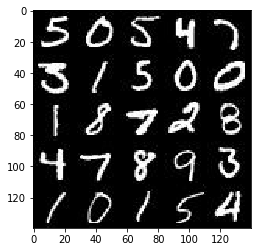

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

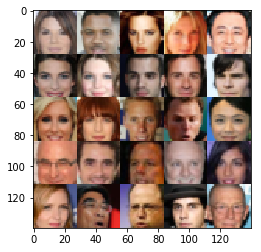

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Images will be 14x14x64
        img1 = tf.layers.conv2d(inputs=images, filters=64, kernel_size=5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * img1, img1)
        
        # Images will be 7x7x128
        img2 = tf.layers.conv2d(inputs=relu1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(img2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # Images will be 4x4x256
        img3 = tf.layers.conv2d(inputs=relu2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(img3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # Reuse only if not training
    reuse = False if is_train else True
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer: dim will be 7x7x512
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it to start convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 7x7x512
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        # 7x7x256
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 14x14x128
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        # 14x14x128
        x5 = tf.layers.conv2d_transpose(x4, 64, 5, strides=2, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        
        # Output layer 28x28x5
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    losses = []
    steps = 0
    show_every = 100
    print_every = 10
    n_images = 25
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z,  data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8568... Generator Loss: 0.7442
Epoch 1/2... Discriminator Loss: 0.4712... Generator Loss: 1.3670
Epoch 1/2... Discriminator Loss: 0.2281... Generator Loss: 1.9658
Epoch 1/2... Discriminator Loss: 0.4198... Generator Loss: 1.2493
Epoch 1/2... Discriminator Loss: 0.2742... Generator Loss: 3.5444
Epoch 1/2... Discriminator Loss: 2.4345... Generator Loss: 0.1445
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 0.6098
Epoch 1/2... Discriminator Loss: 0.4911... Generator Loss: 2.2136
Epoch 1/2... Discriminator Loss: 0.5232... Generator Loss: 1.3217
Epoch 1/2... Discriminator Loss: 0.2464... Generator Loss: 2.1000


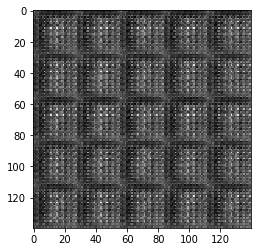

Epoch 1/2... Discriminator Loss: 0.1725... Generator Loss: 2.2859
Epoch 1/2... Discriminator Loss: 0.1797... Generator Loss: 2.5123
Epoch 1/2... Discriminator Loss: 0.3838... Generator Loss: 1.9817
Epoch 1/2... Discriminator Loss: 0.1514... Generator Loss: 2.6803
Epoch 1/2... Discriminator Loss: 0.4472... Generator Loss: 1.3544
Epoch 1/2... Discriminator Loss: 0.1799... Generator Loss: 2.4461
Epoch 1/2... Discriminator Loss: 0.1611... Generator Loss: 3.3802
Epoch 1/2... Discriminator Loss: 0.1726... Generator Loss: 2.4532
Epoch 1/2... Discriminator Loss: 0.2148... Generator Loss: 2.1648
Epoch 1/2... Discriminator Loss: 0.2687... Generator Loss: 1.8086


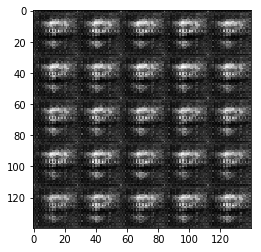

Epoch 1/2... Discriminator Loss: 0.0791... Generator Loss: 3.2543
Epoch 1/2... Discriminator Loss: 0.1757... Generator Loss: 2.7946
Epoch 1/2... Discriminator Loss: 0.1621... Generator Loss: 3.1054
Epoch 1/2... Discriminator Loss: 0.2861... Generator Loss: 1.4405
Epoch 1/2... Discriminator Loss: 0.6474... Generator Loss: 9.5785
Epoch 1/2... Discriminator Loss: 0.0935... Generator Loss: 2.8247
Epoch 1/2... Discriminator Loss: 0.1936... Generator Loss: 2.3286
Epoch 1/2... Discriminator Loss: 0.6677... Generator Loss: 10.1392
Epoch 1/2... Discriminator Loss: 0.1002... Generator Loss: 3.2091
Epoch 1/2... Discriminator Loss: 0.1639... Generator Loss: 2.7065


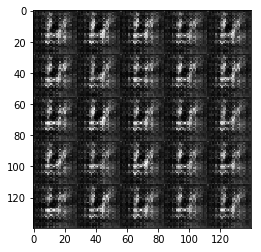

Epoch 1/2... Discriminator Loss: 0.1670... Generator Loss: 2.5404
Epoch 1/2... Discriminator Loss: 0.2717... Generator Loss: 1.8879
Epoch 1/2... Discriminator Loss: 1.0143... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 0.9606... Generator Loss: 1.4016
Epoch 1/2... Discriminator Loss: 0.2914... Generator Loss: 2.2922
Epoch 1/2... Discriminator Loss: 0.2969... Generator Loss: 2.0299
Epoch 1/2... Discriminator Loss: 0.2712... Generator Loss: 1.9759
Epoch 1/2... Discriminator Loss: 0.2866... Generator Loss: 2.0349
Epoch 1/2... Discriminator Loss: 0.7072... Generator Loss: 0.9247
Epoch 1/2... Discriminator Loss: 0.3198... Generator Loss: 2.2318


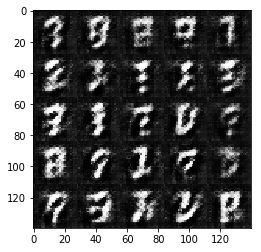

Epoch 1/2... Discriminator Loss: 0.7411... Generator Loss: 3.8338
Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 0.6374
Epoch 1/2... Discriminator Loss: 0.6203... Generator Loss: 3.7806
Epoch 1/2... Discriminator Loss: 0.5546... Generator Loss: 1.2280
Epoch 1/2... Discriminator Loss: 1.4138... Generator Loss: 4.3992
Epoch 1/2... Discriminator Loss: 0.5714... Generator Loss: 1.7591
Epoch 1/2... Discriminator Loss: 0.6712... Generator Loss: 3.0634
Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 3.7088
Epoch 1/2... Discriminator Loss: 0.7548... Generator Loss: 2.7223
Epoch 1/2... Discriminator Loss: 0.6874... Generator Loss: 0.9334


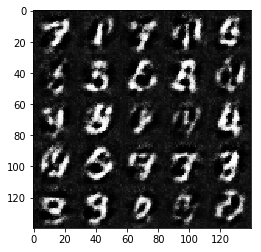

Epoch 1/2... Discriminator Loss: 0.5942... Generator Loss: 1.1487
Epoch 1/2... Discriminator Loss: 0.7144... Generator Loss: 1.2671
Epoch 1/2... Discriminator Loss: 0.6501... Generator Loss: 1.4974
Epoch 1/2... Discriminator Loss: 0.8099... Generator Loss: 0.7838
Epoch 1/2... Discriminator Loss: 0.5540... Generator Loss: 1.5243
Epoch 1/2... Discriminator Loss: 0.7649... Generator Loss: 1.1538
Epoch 1/2... Discriminator Loss: 0.5298... Generator Loss: 1.2561
Epoch 1/2... Discriminator Loss: 0.4872... Generator Loss: 1.6350
Epoch 1/2... Discriminator Loss: 0.6869... Generator Loss: 1.0030
Epoch 1/2... Discriminator Loss: 0.5574... Generator Loss: 1.2380


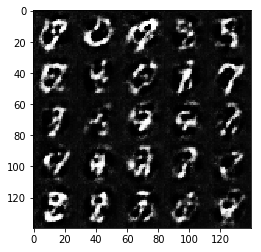

Epoch 1/2... Discriminator Loss: 0.5940... Generator Loss: 1.0957
Epoch 1/2... Discriminator Loss: 0.5834... Generator Loss: 2.0143
Epoch 1/2... Discriminator Loss: 0.5611... Generator Loss: 1.1917
Epoch 1/2... Discriminator Loss: 0.5197... Generator Loss: 1.5909
Epoch 1/2... Discriminator Loss: 1.7017... Generator Loss: 0.2735
Epoch 1/2... Discriminator Loss: 0.5542... Generator Loss: 1.3214
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 0.5196... Generator Loss: 1.5069
Epoch 1/2... Discriminator Loss: 0.9148... Generator Loss: 2.2080
Epoch 1/2... Discriminator Loss: 0.6047... Generator Loss: 1.0390


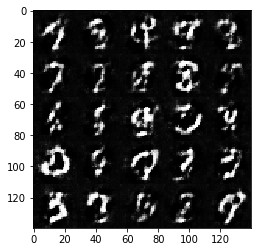

Epoch 1/2... Discriminator Loss: 0.7780... Generator Loss: 0.8122
Epoch 1/2... Discriminator Loss: 0.5243... Generator Loss: 1.7471
Epoch 1/2... Discriminator Loss: 0.6134... Generator Loss: 1.0823
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.4140
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 0.4753
Epoch 1/2... Discriminator Loss: 0.7738... Generator Loss: 1.2536
Epoch 1/2... Discriminator Loss: 0.5530... Generator Loss: 1.3058
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 3.1551
Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 0.5403
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 0.4676


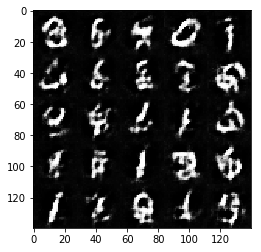

Epoch 1/2... Discriminator Loss: 0.8276... Generator Loss: 0.9186
Epoch 1/2... Discriminator Loss: 0.8829... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 0.7238... Generator Loss: 2.0189
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.3554
Epoch 1/2... Discriminator Loss: 0.8214... Generator Loss: 2.1816
Epoch 1/2... Discriminator Loss: 0.9288... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 0.8203... Generator Loss: 0.9359
Epoch 1/2... Discriminator Loss: 0.7759... Generator Loss: 1.3330
Epoch 1/2... Discriminator Loss: 0.8947... Generator Loss: 1.4305
Epoch 1/2... Discriminator Loss: 0.7004... Generator Loss: 1.2695


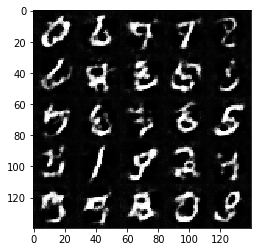

Epoch 1/2... Discriminator Loss: 0.9047... Generator Loss: 1.6070
Epoch 1/2... Discriminator Loss: 0.9764... Generator Loss: 2.2848
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 0.4832
Epoch 2/2... Discriminator Loss: 1.2400... Generator Loss: 1.7837
Epoch 2/2... Discriminator Loss: 0.8410... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 0.9704
Epoch 2/2... Discriminator Loss: 1.0913... Generator Loss: 0.5545
Epoch 2/2... Discriminator Loss: 0.8503... Generator Loss: 1.2625
Epoch 2/2... Discriminator Loss: 0.7990... Generator Loss: 1.2213
Epoch 2/2... Discriminator Loss: 0.9660... Generator Loss: 0.8948


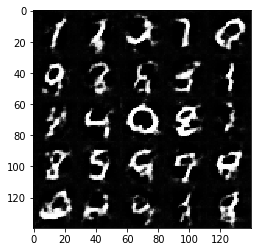

Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 2.3557
Epoch 2/2... Discriminator Loss: 0.9834... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 1.1413... Generator Loss: 1.9638
Epoch 2/2... Discriminator Loss: 0.9978... Generator Loss: 0.8603
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 1.2899
Epoch 2/2... Discriminator Loss: 0.8344... Generator Loss: 1.1374
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 0.9546... Generator Loss: 0.7732
Epoch 2/2... Discriminator Loss: 0.7895... Generator Loss: 1.2570
Epoch 2/2... Discriminator Loss: 0.8045... Generator Loss: 1.4259


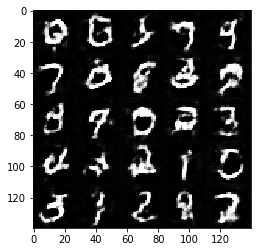

Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 0.5291
Epoch 2/2... Discriminator Loss: 0.8914... Generator Loss: 1.4375
Epoch 2/2... Discriminator Loss: 1.0811... Generator Loss: 0.5765
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 1.8235
Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.5388
Epoch 2/2... Discriminator Loss: 0.8305... Generator Loss: 1.1650
Epoch 2/2... Discriminator Loss: 1.6470... Generator Loss: 0.2751
Epoch 2/2... Discriminator Loss: 0.8743... Generator Loss: 0.8141
Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 1.9962
Epoch 2/2... Discriminator Loss: 0.8168... Generator Loss: 1.4540


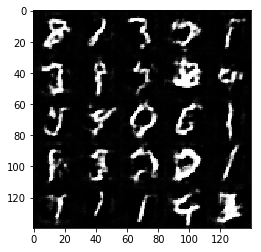

Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 1.5181
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 1.0634
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.0738... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 1.8071
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 1.0029
Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 1.3749... Generator Loss: 2.2808
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 0.8616
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.4440


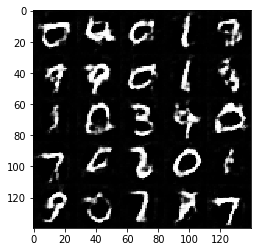

Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 0.4680
Epoch 2/2... Discriminator Loss: 0.9359... Generator Loss: 0.7868
Epoch 2/2... Discriminator Loss: 1.5719... Generator Loss: 0.2943
Epoch 2/2... Discriminator Loss: 0.9823... Generator Loss: 0.8078
Epoch 2/2... Discriminator Loss: 0.9936... Generator Loss: 1.5060
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.2874
Epoch 2/2... Discriminator Loss: 0.9074... Generator Loss: 0.8180
Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 0.6791
Epoch 2/2... Discriminator Loss: 0.9826... Generator Loss: 0.6659
Epoch 2/2... Discriminator Loss: 1.0181... Generator Loss: 0.7803


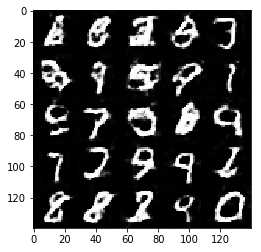

Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 1.6776
Epoch 2/2... Discriminator Loss: 1.1883... Generator Loss: 0.4913
Epoch 2/2... Discriminator Loss: 0.9045... Generator Loss: 1.2376
Epoch 2/2... Discriminator Loss: 0.9509... Generator Loss: 1.0114
Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 0.3788
Epoch 2/2... Discriminator Loss: 0.9511... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 1.1286
Epoch 2/2... Discriminator Loss: 0.8374... Generator Loss: 1.1784
Epoch 2/2... Discriminator Loss: 1.0316... Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.0860... Generator Loss: 1.3703


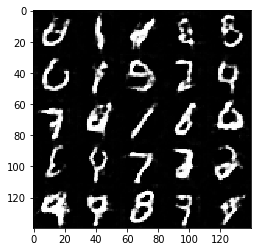

Epoch 2/2... Discriminator Loss: 0.8741... Generator Loss: 1.2642
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.4237
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 0.5638
Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 1.3264
Epoch 2/2... Discriminator Loss: 1.1580... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 0.8914... Generator Loss: 1.0870
Epoch 2/2... Discriminator Loss: 0.9937... Generator Loss: 0.6928
Epoch 2/2... Discriminator Loss: 1.0504... Generator Loss: 0.6458
Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 1.7917
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 0.9000


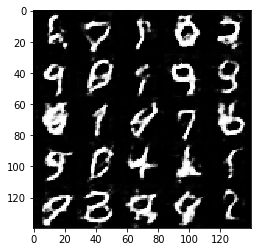

Epoch 2/2... Discriminator Loss: 0.8897... Generator Loss: 1.2891
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.5725
Epoch 2/2... Discriminator Loss: 1.4334... Generator Loss: 0.3867
Epoch 2/2... Discriminator Loss: 0.9533... Generator Loss: 0.7102
Epoch 2/2... Discriminator Loss: 0.9452... Generator Loss: 1.1863
Epoch 2/2... Discriminator Loss: 0.7508... Generator Loss: 0.9506
Epoch 2/2... Discriminator Loss: 1.1279... Generator Loss: 0.5438
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.3613
Epoch 2/2... Discriminator Loss: 1.5978... Generator Loss: 0.3031
Epoch 2/2... Discriminator Loss: 0.8006... Generator Loss: 1.2219


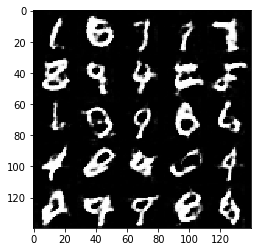

Epoch 2/2... Discriminator Loss: 1.0430... Generator Loss: 0.6673
Epoch 2/2... Discriminator Loss: 0.8729... Generator Loss: 1.3937
Epoch 2/2... Discriminator Loss: 1.8006... Generator Loss: 0.2421
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 1.0306
Epoch 2/2... Discriminator Loss: 0.8165... Generator Loss: 0.8556
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 1.1341
Epoch 2/2... Discriminator Loss: 1.0676... Generator Loss: 0.5971
Epoch 2/2... Discriminator Loss: 0.9687... Generator Loss: 0.6955
Epoch 2/2... Discriminator Loss: 1.5017... Generator Loss: 0.3230
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 1.5027


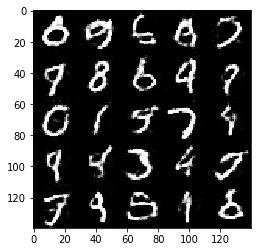

Epoch 2/2... Discriminator Loss: 1.1267... Generator Loss: 0.5173
Epoch 2/2... Discriminator Loss: 0.7333... Generator Loss: 1.4519
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 0.6924
Epoch 2/2... Discriminator Loss: 0.9138... Generator Loss: 1.2572
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.5103
Epoch 2/2... Discriminator Loss: 0.7866... Generator Loss: 1.0181
Epoch 2/2... Discriminator Loss: 0.8011... Generator Loss: 1.0082


In [14]:
batch_size = 64
z_dim = 150
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 1.1144
Epoch 1/1... Discriminator Loss: 0.4421... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 0.3657... Generator Loss: 1.7961
Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 1.7246
Epoch 1/1... Discriminator Loss: 0.1952... Generator Loss: 2.3060
Epoch 1/1... Discriminator Loss: 0.2612... Generator Loss: 2.0747
Epoch 1/1... Discriminator Loss: 0.1458... Generator Loss: 2.9477
Epoch 1/1... Discriminator Loss: 0.3242... Generator Loss: 1.4214
Epoch 1/1... Discriminator Loss: 0.3170... Generator Loss: 4.7535


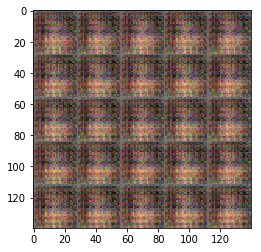

Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 0.1258... Generator Loss: 3.0713
Epoch 1/1... Discriminator Loss: 0.0898... Generator Loss: 3.4418
Epoch 1/1... Discriminator Loss: 0.0962... Generator Loss: 4.7755
Epoch 1/1... Discriminator Loss: 0.5044... Generator Loss: 2.8933
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 0.1118... Generator Loss: 3.7680
Epoch 1/1... Discriminator Loss: 0.3255... Generator Loss: 3.0732
Epoch 1/1... Discriminator Loss: 0.1402... Generator Loss: 2.6808
Epoch 1/1... Discriminator Loss: 0.2574... Generator Loss: 2.3145


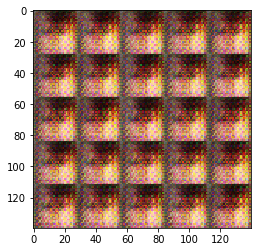

Epoch 1/1... Discriminator Loss: 0.5152... Generator Loss: 1.5367
Epoch 1/1... Discriminator Loss: 0.2249... Generator Loss: 2.4057
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 4.1890
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 2.0768
Epoch 1/1... Discriminator Loss: 0.6533... Generator Loss: 1.0839
Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 2.3470
Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 2.2568
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 0.4211... Generator Loss: 1.9293
Epoch 1/1... Discriminator Loss: 0.6277... Generator Loss: 2.9262


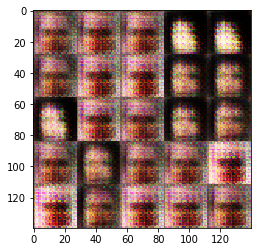

Epoch 1/1... Discriminator Loss: 0.6351... Generator Loss: 1.5318
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 1.9485
Epoch 1/1... Discriminator Loss: 0.5703... Generator Loss: 2.7199
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.2865
Epoch 1/1... Discriminator Loss: 0.6546... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 4.0535
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 3.1665
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 2.1544
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.6149
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 0.8312


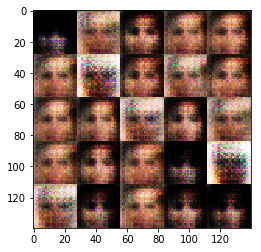

Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 0.5982... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 0.5868... Generator Loss: 1.3596
Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 1.4816
Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 0.4488... Generator Loss: 1.7825
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.0585
Epoch 1/1... Discriminator Loss: 0.4440... Generator Loss: 2.0937
Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 1.1229


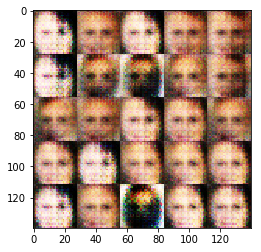

Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 4.0288
Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 2.0882
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 1.4574
Epoch 1/1... Discriminator Loss: 0.5739... Generator Loss: 1.2228
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 2.6464
Epoch 1/1... Discriminator Loss: 0.4283... Generator Loss: 1.5488
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 1.9960
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 2.3241


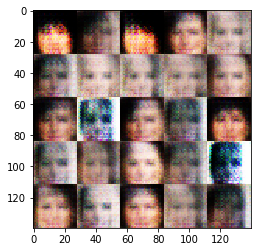

Epoch 1/1... Discriminator Loss: 0.5493... Generator Loss: 2.0049
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 4.2967
Epoch 1/1... Discriminator Loss: 0.5585... Generator Loss: 1.8117
Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 1.5642
Epoch 1/1... Discriminator Loss: 0.4618... Generator Loss: 2.6984
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 1.7507
Epoch 1/1... Discriminator Loss: 0.5913... Generator Loss: 1.2508
Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 1.9527
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 3.7630
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 0.5774


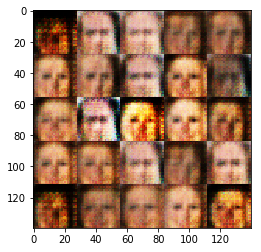

Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 2.2992
Epoch 1/1... Discriminator Loss: 0.4960... Generator Loss: 1.9859
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 1.3337
Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 1.4359
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 1.6411
Epoch 1/1... Discriminator Loss: 0.5652... Generator Loss: 1.5080
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 3.7417
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 1.9032
Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 1.5736


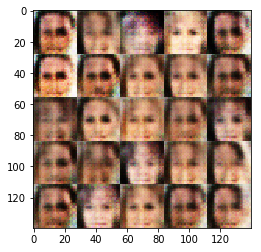

Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.2000
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 1.8686
Epoch 1/1... Discriminator Loss: 0.4585... Generator Loss: 1.5261
Epoch 1/1... Discriminator Loss: 0.4751... Generator Loss: 1.9676
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.1944
Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 1.3620
Epoch 1/1... Discriminator Loss: 0.5610... Generator Loss: 1.4730
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 1.4012
Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.7790
Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 1.0493


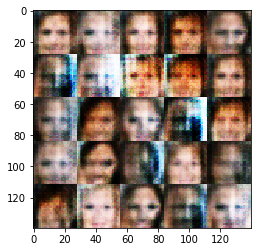

Epoch 1/1... Discriminator Loss: 0.4714... Generator Loss: 1.8639
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.3935
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 1.5805
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 1.7967
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.8541


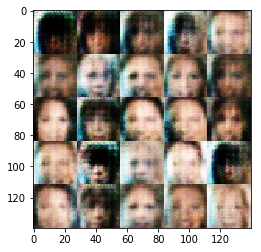

Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 2.1220
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 2.1041
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.3176
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.3137
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.6806
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 2.7062
Epoch 1/1... Discriminator Loss: 0.8286... Generator Loss: 2.2059
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 1.1984
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 0.9427


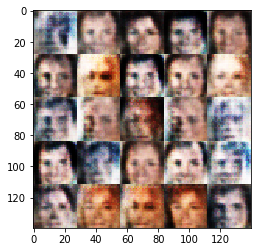

Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.7649
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 2.5686
Epoch 1/1... Discriminator Loss: 0.8459... Generator Loss: 1.3036
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 1.2136
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.3993
Epoch 1/1... Discriminator Loss: 0.7397... Generator Loss: 1.4617
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 1.4435


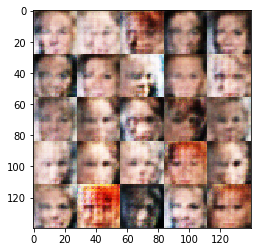

Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.9651
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 1.1273
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.5639
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.3386
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 2.1055
Epoch 1/1... Discriminator Loss: 0.8144... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 0.8650


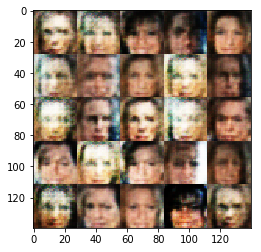

Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 0.7812


KeyboardInterrupt: 

In [15]:
batch_size = 128
z_dim = 200
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.